Udacity Data Scientist Nanodegree
===============
Project 1: Draw me a data scientist
===============


# Introduction
The Data Science field has become popular over the past ten years and the demand of data science professionals is increasing in company. Here we look at what Data Science professional look like using the CRISP-DM methodology, used in Data Science projects.



**Table of contents:**

- [Business Understanding](#item-one)
- [Data Understanding](#item-two)
- [Data Preparation](#item-three)
- [Evaluation](#item-four)
- [Setting out](#item-five)
 






<a id="item-one"></a>
# Business Understanding
Using the Stack Overflow Survey from 2022, I asked the following questions:


- Question 1: What programming languages do data science people work with and what should I focus on if I pick a DS role?
- Question 2: What programming languages and cloud platforms are in demand?
- Question 3: How well are Data Science roles paid in the US?


In [2]:
#loading needed libraries
import numpy as np
import pandas as pd
from IPython import display
import matplotlib as plt
import seaborn as sns

<a id="item-two"></a>
# Data Understanding
## Load data

In [3]:

df2022 = pd.read_csv('./survey_results_public2022.csv')
df2022.shape

(73268, 79)

In 2022, more than 73000 people answered the survey in Stack Overflow

In [4]:
#Let's take a look at the column headers
df2022.columns

Index(['ResponseId', 'MainBranch', 'Employment', 'RemoteWork',
       'CodingActivities', 'EdLevel', 'LearnCode', 'LearnCodeOnline',
       'LearnCodeCoursesCert', 'YearsCode', 'YearsCodePro', 'DevType',
       'OrgSize', 'PurchaseInfluence', 'BuyNewTool', 'Country', 'Currency',
       'CompTotal', 'CompFreq', 'LanguageHaveWorkedWith',
       'LanguageWantToWorkWith', 'DatabaseHaveWorkedWith',
       'DatabaseWantToWorkWith', 'PlatformHaveWorkedWith',
       'PlatformWantToWorkWith', 'WebframeHaveWorkedWith',
       'WebframeWantToWorkWith', 'MiscTechHaveWorkedWith',
       'MiscTechWantToWorkWith', 'ToolsTechHaveWorkedWith',
       'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith',
       'NEWCollabToolsWantToWorkWith', 'OpSysProfessional use',
       'OpSysPersonal use', 'VersionControlSystem', 'VCInteraction',
       'VCHostingPersonal use', 'VCHostingProfessional use',
       'OfficeStackAsyncHaveWorkedWith', 'OfficeStackAsyncWantToWorkWith',
       'OfficeStackSyncHaveWork

My questions are related to the Data Science field so I will first subset the survey results by data science jobs.

<a id="item-three"></a>
# Data Preparation

In [5]:
df2022['DevType'].unique()

array([nan,
       'Data scientist or machine learning specialist;Developer, front-end;Engineer, data;Engineer, site reliability',
       'Developer, full-stack', ...,
       'Data scientist or machine learning specialist;Developer, front-end;Developer, full-stack;Developer, back-end;Developer, QA or test;Developer, mobile;Database administrator;Cloud infrastructure engineer;Data or business analyst;Designer;Blockchain',
       'Developer, front-end;Developer, full-stack;Developer, back-end;Developer, desktop or enterprise applications;Developer, mobile;Educator;Developer, embedded applications or devices',
       'Developer, front-end;Engineer, data;Engineer, site reliability;Developer, full-stack;Developer, back-end;Developer, desktop or enterprise applications;Developer, QA or test;Student;Developer, mobile;Academic researcher;DevOps specialist;Developer, embedded applications or devices;Developer, game or graphics;Cloud infrastructure engineer;Data or business analyst;Designer;Scie

A lot of the participants have different DevType roles, so we first need to expode the DevType column, before subsetting. 

In [6]:
df2022_explode_devtype = df2022.assign(devtype=df2022.DevType.str.split(';')).explode('devtype').reset_index(drop=True)


In [7]:
df2022_explode_devtype['devtype'].value_counts()

Developer, full-stack                            28701
Developer, back-end                              26595
Developer, front-end                             15915
Developer, desktop or enterprise applications     9546
Developer, mobile                                 7634
DevOps specialist                                 6170
Student                                           5595
Cloud infrastructure engineer                     5283
Database administrator                            4934
System administrator                              4908
Developer, embedded applications or devices       3923
Project manager                                   3897
Designer                                          3764
Engineer, data                                    3600
Engineering manager                               3574
Data scientist or machine learning specialist     3424
Data or business analyst                          3201
Developer, QA or test                             3096
Academic r

I will subset all the rows that have devtype as Data scientist or machine learning specialist, Data or business analyst  and Engineer, data

In [8]:
data=['Engineer, data', 'Data scientist or machine learning specialist','Data or business analyst']
df2022_DS=df2022_explode_devtype[df2022_explode_devtype['devtype'].isin(data)]
df2022_DS['devtype'].unique(), df2022_DS.shape

(array(['Data scientist or machine learning specialist', 'Engineer, data',
        'Data or business analyst'], dtype=object),
 (10225, 80))

In [9]:
df2022_DS.index.nunique() # this is the number of participants

10225

Interestingly, there are no replicated indexes so no participant considered themselves more than one devtype among the DS roles.

<Axes: title={'center': 'Distribution of participants doing Data Science, by DS role'}>

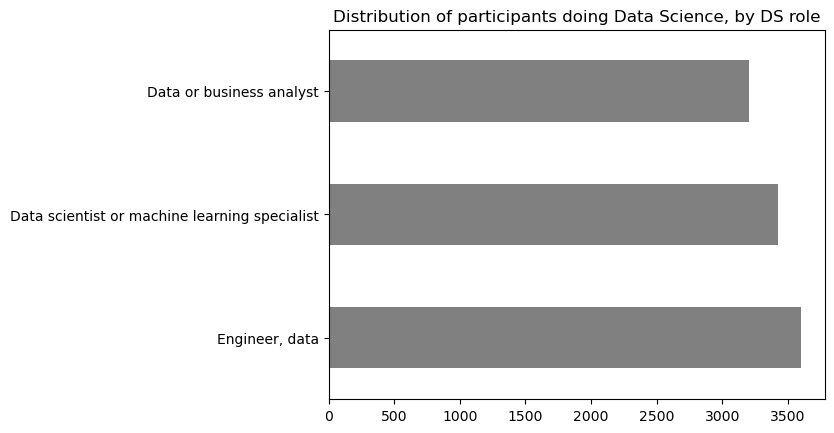

In [10]:
#distribution of devtype in DS
df2022_DS.devtype.value_counts().plot(kind='barh',color='grey',title='Distribution of participants doing Data Science, by DS role')

In [11]:
df2022_DS.devtype.value_counts()

Engineer, data                                   3600
Data scientist or machine learning specialist    3424
Data or business analyst                         3201
Name: devtype, dtype: int64

Among these >10000 DS participants, about 1/3 were either one of the three devtypes, but there is the most of data engineers.

<a id="item-four"></a>
# Evaluation

## Question 1: What programming languages do data science people work with and what should I focus on if I pick a DS role?

Let's take a look at the features I want to examine.

In [12]:
df2022_DS['devtype'].unique()

array(['Data scientist or machine learning specialist', 'Engineer, data',
       'Data or business analyst'], dtype=object)

In [13]:
df2022_DS.LanguageHaveWorkedWith.nunique()

4399

In [14]:
df2022_DS.LanguageWantToWorkWith.nunique()

4173

These features have the same challenge as platform features, so I have to use explode() to separate the values and get counts for each language. The plan: separate devtype into new rows, then subset by devtypes, then explode each language column to make counts per dev type.

First, I want to see what languages DS professionals use.

#### I am creating a function that will process my dataframe with the column of interest and output the plot I am interested in. I will use this function in other sections of the notebook.

In [65]:
#creating a function to prepare and visualize a columns that contains more than one value and visualize the data by group
def multivalue_plot_bygroup(df,column_name,new_col,groupby):
    '''This function takes a column of the dataframe that has more than one value and separated values to put them in a new row. 
    It outputs a list of unique values for the columns and a plot show the value counts of the column by group specified.
    
    Input:
        df: specify the dataframe
        column_name: specify the column name you want to process
        new_col: specify a name for the new column
        groupby: specify the column by which you want to group counts
    
    Output:
        unique : list of unique values
        plot : plot of value counts
    
    '''
    explode = df.assign(new_col=df[column_name].str.split(';')).explode('new_col').reset_index(drop=True)
    unique = explode['new_col'].unique()
    plot = explode.groupby(['new_col'])[groupby].value_counts().unstack().plot(kind='barh', stacked=True,colormap='tab20b',figsize=(15,10))
    
    return unique
    return plot


array(['C#', 'C++', 'HTML/CSS', 'JavaScript', 'Python', 'SQL',
       'Bash/Shell', 'Groovy', 'Java', 'Perl', 'PHP', 'Scala',
       'TypeScript', 'VBA', 'Julia', 'R', 'Go', 'Rust', 'Clojure', 'C',
       'Ruby', 'MATLAB', 'Dart', 'APL', 'Assembly', 'Kotlin', 'Elixir',
       'Erlang', 'PowerShell', 'SAS', 'Haskell', 'F#', 'OCaml', 'Swift',
       'LISP', 'Solidity', 'Lua', 'Objective-C', 'Delphi', 'Fortran',
       'COBOL', 'Crystal', nan], dtype=object)

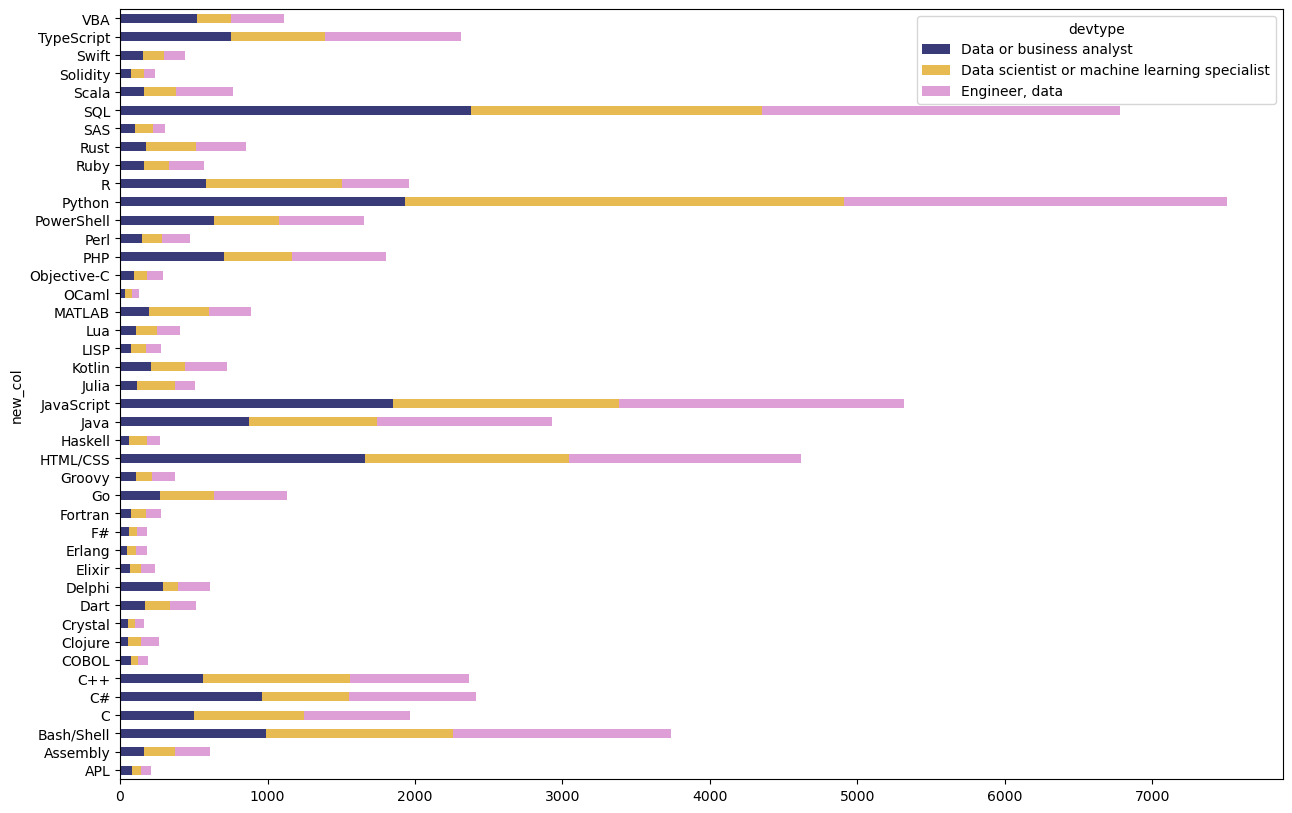

In [66]:
multivalue_plot_bygroup(df2022_DS, 'LanguageHaveWorkedWith', 'language', 'devtype')

Let's keep in mind that the participants here select a DS role as their devtype but they can also be other devtype, this is something we can look closer to explain the distribution of other languages than Python, R or SQL.

Next I wanted to know, if I decide to go for one of the DS roles, what type of languages should I focus on

In [69]:
# among the languages that are usually used by data science people, who uses most of which language?
DS_lang=['SQL','Python','R','Bash/Shell']
df2022_DS_explode_currentlanguage = df2022_DS.assign(language=df2022_DS.LanguageHaveWorkedWith.str.split(';')).explode('language').reset_index(drop=True)
df2022_DSlang = df2022_DS_explode_currentlanguage[df2022_DS_explode_currentlanguage['language'].isin(DS_lang)]
df2022_DSlang['language'].unique()

array(['Python', 'SQL', 'Bash/Shell', 'R'], dtype=object)

<Axes: title={'center': 'Language focus for each Data Science role: proportion of language use by DS role'}, ylabel='devtype'>

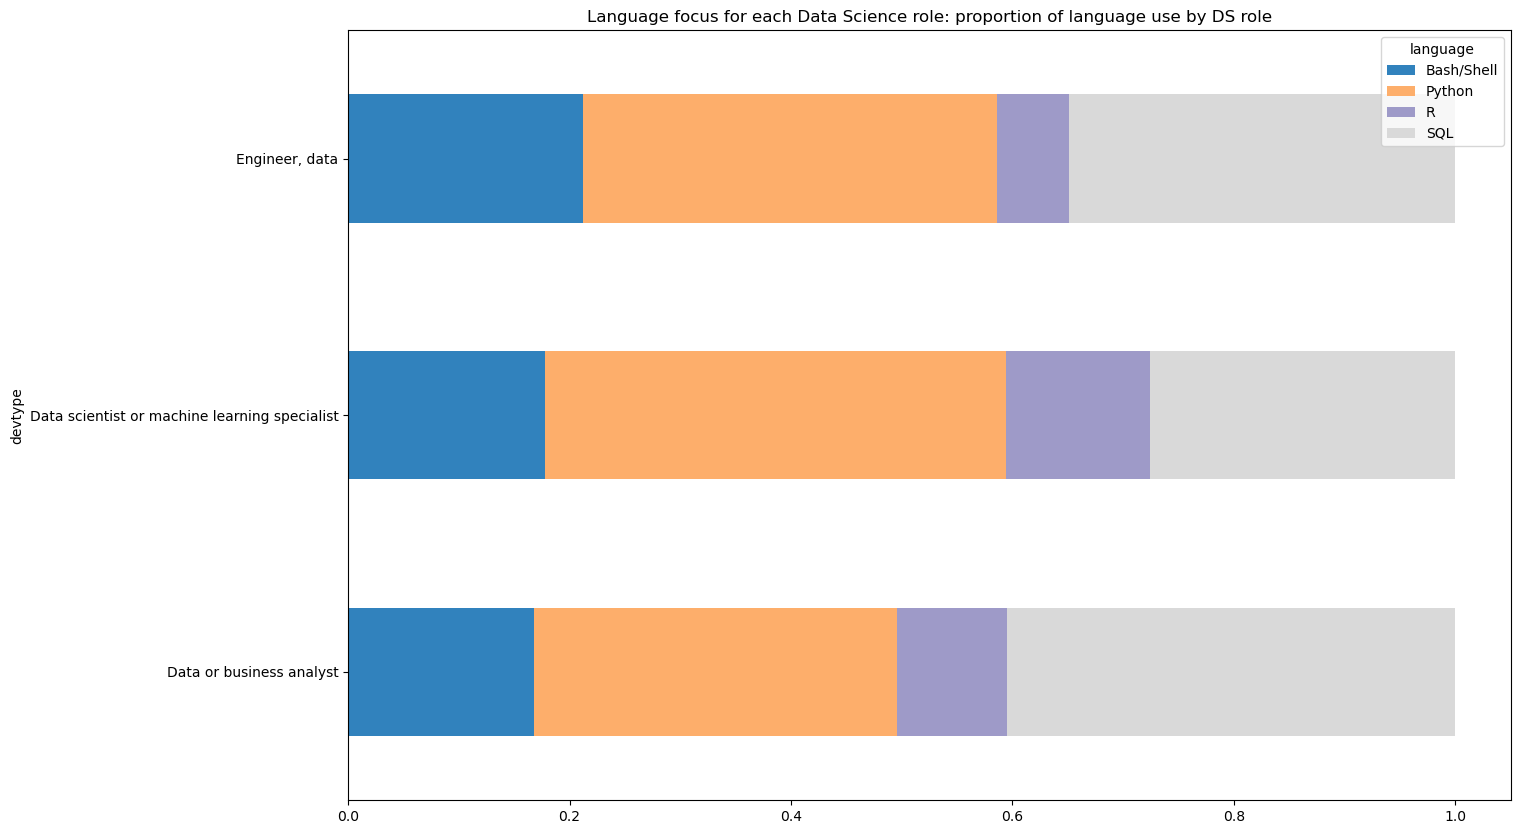

In [17]:
df2022_DSlang.groupby(['devtype'])['language'].value_counts(normalize=True).unstack().plot(kind='barh', stacked=True,colormap='tab20c',figsize=(15,10), title='Language focus for each Data Science role: proportion of language use by DS role')

A data engineer with use more Bach/Shell and Python and SQL, while a Data Scientist uses more Python and R, and finally a data analyst uses a lot of SQL.

## Question 2: What programming languages are in demand?

Now let's look at what language DS participants want to learn more of.

array(['C#', 'C++', 'HTML/CSS', 'JavaScript', 'TypeScript', 'Python',
       'SQL', 'Bash/Shell', 'Dart', 'Go', 'Groovy', 'Java', 'Perl',
       'Scala', nan, 'Assembly', 'Rust', 'Solidity', 'Clojure', 'Kotlin',
       'VBA', 'R', 'F#', 'Julia', 'Elixir', 'C', 'LISP', 'Ruby',
       'Haskell', 'Swift', 'PowerShell', 'OCaml', 'PHP', 'Erlang',
       'Crystal', 'Lua', 'Objective-C', 'Delphi', 'APL', 'MATLAB',
       'Fortran', 'COBOL', 'SAS'], dtype=object)

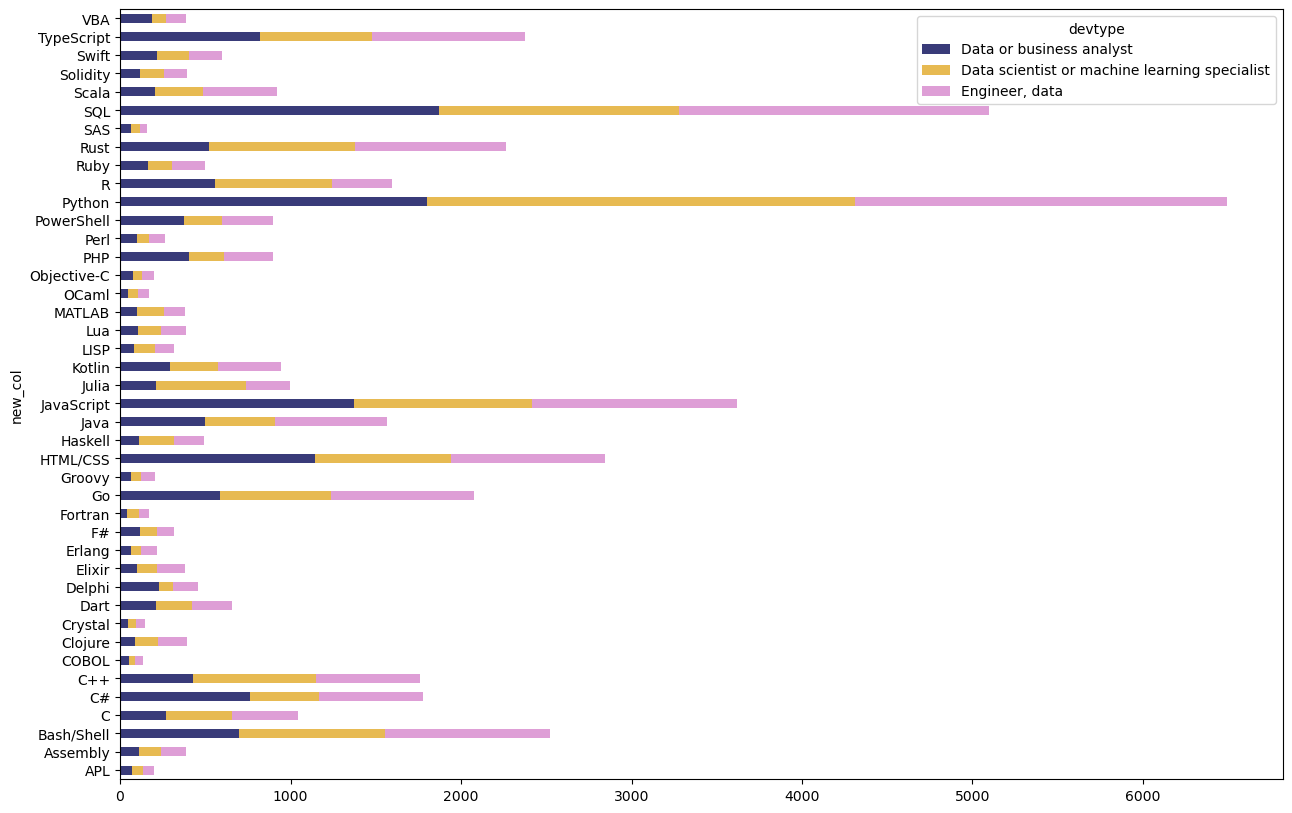

In [67]:
multivalue_plot_bygroup(df2022_DS, 'LanguageWantToWorkWith', 'language', 'devtype')

To estimate the demand for both language and platform demand, I calculated the difference of proportion of people wanting to learn a new language/platform and the proportion of people using the language/platform.

demand = proportion language or platform want to work on - proportion platform using

In [70]:
df2022_DS_explode_wantlanguage = df2022_DS.assign(language=df2022_DS.LanguageWantToWorkWith.str.split(';')).explode('language').reset_index(drop=True)
difL = df2022_DS_explode_wantlanguage.groupby(['language'])['devtype'].value_counts(normalize=True)-df2022_DS_explode_currentlanguage.groupby(['language'])['devtype'].value_counts(normalize=True)



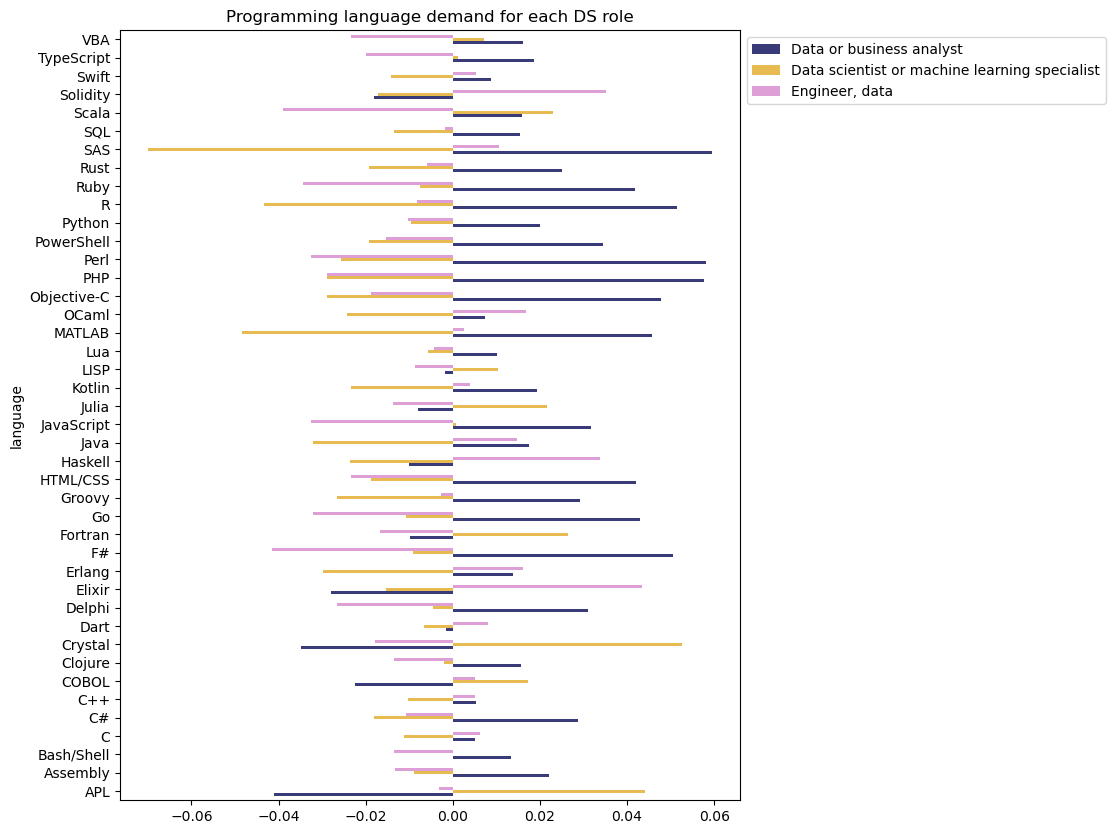

In [71]:
difL.unstack().plot(kind='barh',colormap='tab20b',figsize=(8, 10),title='Programming language demand for each DS role').legend(bbox_to_anchor=(1.0, 1.0))

Here we see again that data analysts selected the most new languages they want to learn as opposed to Data Scientist and Data Engineers.


## Question 3: What cloud platforms are in demand ?
To answer this question, we will compare the platforms participants currently work on and the ones they wish to learn how to use.


### Data Analysis

In [21]:
df2022_DS['PlatformHaveWorkedWith'].head()

2                                     NaN
4                                     NaN
33                       AWS;Google Cloud
69                 Microsoft Azure;VMware
71    AWS;Managed Hosting;Microsoft Azure
Name: PlatformHaveWorkedWith, dtype: object

In the survey participant could select more than one platform they use, so to get counts for each platform, we have to separate these values for each cell. This can be done using the function explode()

In [22]:
#explode() by current platform
df2022_DS_explode_currentplatform = df2022_DS.assign(platform=df2022.PlatformHaveWorkedWith.str.split(';')).explode('platform').reset_index(drop=True)


In [23]:
df2022_DS_explode_currentplatform['platform'].unique() 

array([nan, 'Firebase', 'Microsoft Azure', 'DigitalOcean', 'Google Cloud',
       'VMware', 'Heroku', 'AWS', 'Linode', 'OVH', 'Managed Hosting',
       'Colocation', 'IBM Cloud or Watson', 'OpenStack',
       'Oracle Cloud Infrastructure'], dtype=object)

Now we see that the platforms are separated. Explode() separated each value and created a new row with the same info. Let's check how many more rows we have now.


In [24]:
df2022_DS.shape, df2022_DS_explode_currentplatform.shape

((10225, 80), (12917, 81))

There are about 2700 more rows after separating the platform values.

Now let's see what platform are used the most and by what type of DS participant.

In [ ]:
df2022_DS_explode_wantplat = df2022_DS.assign(platform=df2022_DS.PlatformWantToWorkWith.str.split(';')).explode('platform').reset_index(drop=True)


### Data Visualization

Let's visualize the platform counts

[Text(0.5, 0, 'Count'), Text(0, 0.5, 'Platform')]

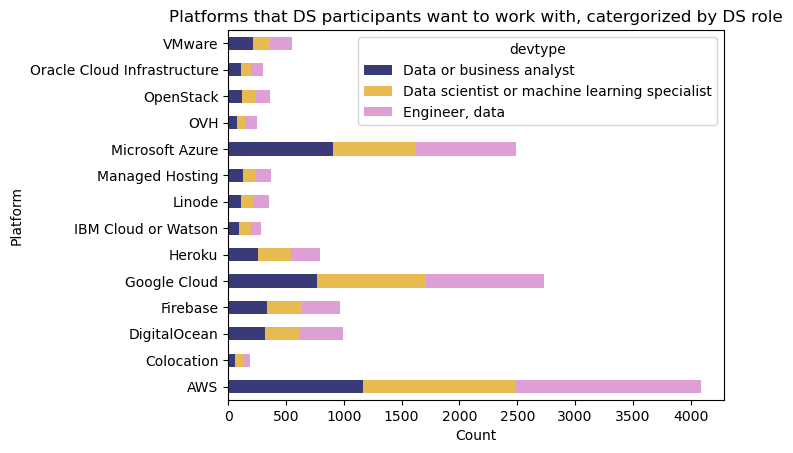

In [72]:
ax2 = df2022_DS_explode_wantplat.groupby(['platform'])['devtype'].value_counts().unstack().plot(kind='barh', stacked=True,colormap='tab20b',title="Platforms that DS participants want to work with, catergorized by DS role")
ax2.set(xlabel='Count', ylabel='Platform')

[Text(0.5, 0, 'Count'), Text(0, 0.5, 'Platform')]

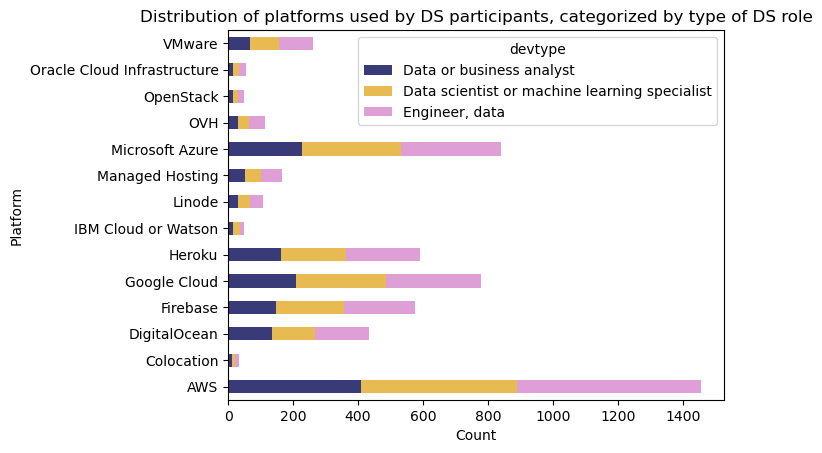

In [73]:
ax1 = df2022_DS_explode_currentplatform.groupby(['platform'])['devtype'].value_counts().unstack().plot(kind='barh', stacked=True,mark_right=True,colormap='tab20b',title='Distribution of platforms used by DS participants, categorized by type of DS role')
ax1.set(xlabel='Count', ylabel='Platform')

In [74]:
demand = df2022_DS_explode_wantplat.groupby(['platform'])['devtype'].value_counts(normalize=True)-df2022_DS_explode_currentplatform.groupby(['platform'])['devtype'].value_counts(normalize=True)



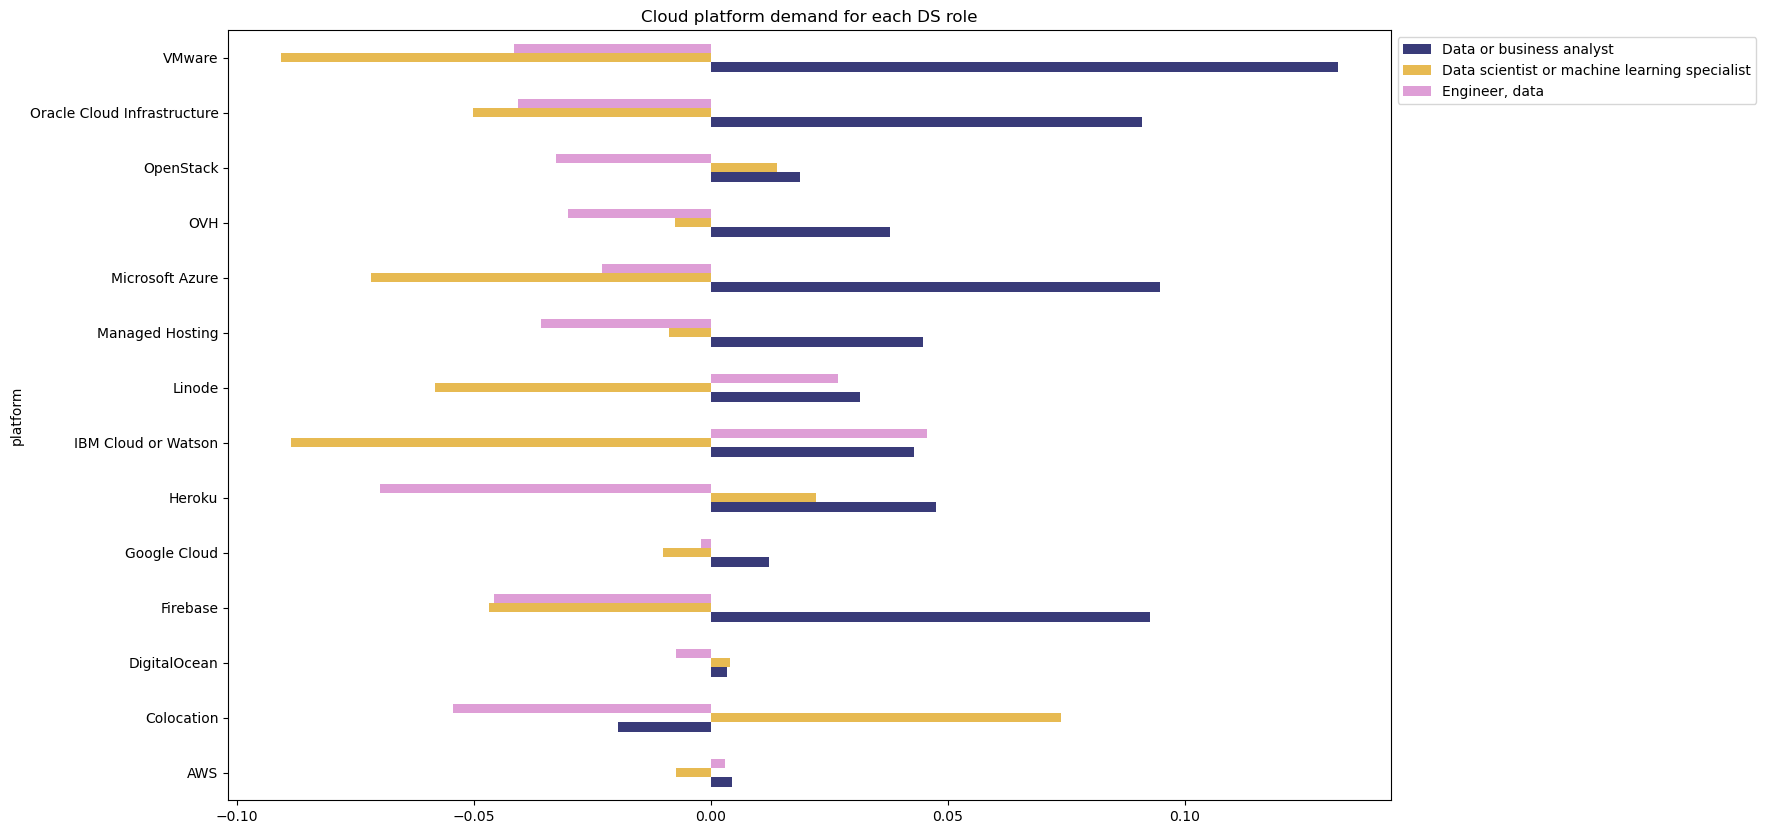

In [75]:
ax3 = demand.unstack().plot(kind='barh',colormap='tab20b',figsize=(15, 10),title='Cloud platform demand for each DS role').legend(bbox_to_anchor=(1.0, 1.0))


In general, there more demand to learn new platforms from data analysts. Data engineers are interested in learning Linode, and IBM Cloud or Watson, and Data Scientists are interested in learning OpenStack, Heroku and Colocation.

## Question 4: How well are Data Science roles paid in the US?

Variables I will be using here are :
- 'YearsCodePro'
- 'ConvertedCompYearly'
- 'devtype'
- 'RemoteWork'

## Data Analysis

In [29]:
#What are the vaues of YearsCodePro?
df2022_DS['YearsCodePro'].unique()

array(['5', '10', '18', '15', '3', nan, '7', '22', '28', '4', '8', '14',
       '12', '11', '19', '20', '37', '2', '1', '40', '6',
       'Less than 1 year', '25', '9', '26', '13', '38', '17', '31', '29',
       '35', '16', '32', '24', '30', '43', '33', '21', '23', '27', '41',
       '34', 'More than 50 years', '45', '36', '50', '42', '46', '39',
       '44', '48', '47'], dtype=object)

YearCodePro is an object because of the strings so we should change the column to a continuous variable before making the plots

In [30]:
#Change YearsCode and YearsCodePro to continuous variable.
# replace strings of 'Less than 1 year' and 'More than 50 years' to 0 and 51
df2022_DS['YearsCodeProNum'] = df2022_DS['YearsCodePro']
df2022_DS.loc[df2022_DS['YearsCodeProNum'] == 'Less than 1 year', 'YearsCodeProNum'] = 0
df2022_DS.loc[df2022_DS['YearsCodeProNum'] == 'More than 50 years','YearsCodeProNum'] = 51
df2022_DS['YearsCodeProNum'] = df2022_DS['YearsCodeProNum'].dropna().astype('float') #changing format


/var/folders/dd/nb8m5vwd1sz3_s49jh1plcfr0000gn/T/ipykernel_18185/1418905998.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2022_DS['YearsCodeProNum'] = df2022_DS['YearsCodePro']
/var/folders/dd/nb8m5vwd1sz3_s49jh1plcfr0000gn/T/ipykernel_18185/1418905998.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2022_DS['YearsCodeProNum'] = df2022_DS['YearsCodeProNum'].dropna().astype('float') #changing format


In [31]:
Compensations vary a lot by countries so for this analysis I will focus on US compensations

SyntaxError: invalid syntax (3427966437.py, line 1)

In [ ]:
#subsetting the survey by participants living in the US 
df2022_DS_USA=df2022_DS[df2022_DS['Country']=='United States of America']

Here is a boxplot showing the distribution of Yearly compensation


In [ ]:
sns.boxplot(y='ConvertedCompYearly',
            data=df2022_DS_USA,title='Distribution of Yearly Compensation for all DS roles in the US')
plt.ticklabel_format(style='plain', axis='y')

There are quite a lot of outliers, and especially the two at the top that squishes the plot so I am going to remove the two outliers...

In [ ]:
#looking at summary statistics without the outliers
df2022_DS_USA[df2022_DS_USA['ConvertedCompYearly']<=1.5e6].groupby('devtype').ConvertedCompYearly.describe().astype(str)

There is a big difference between the mean and median yearly compensations so, there must be a lot of outliers increasing the mean.

In general, the median compensations for each DS role
- Data analyst: 120,000 USD
- Data scientist: 145,000 USD
- Data engineer: 150,000 USD

### Data Visualization

In [ ]:
#setting up my devtype palette for seaborn plots

palette_tab20b = sns.color_palette("tab20b", 20)
palette = sns.color_palette([palette_tab20b[19],palette_tab20b[0],palette_tab20b[10]])
palette


# making a violin plot to visualize distribution
sns.violinplot(x='devtype',y='ConvertedCompYearly',
            data=df2022_DS_USA[df2022_DS_USA['ConvertedCompYearly']<=1e6],
            palette=palette).set(title="How much do Data Science roles earn in the US?")
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)



Conclusion: salary mean is biased by very high outliers, better look at the median salary.

Yearly compensation depends on more factors than just DS role. So let's dig into a few of them. 

First, yearly compensation must vary with years of experience coding professionally. Let's check if this is the trend


In [ ]:
sns.lmplot(x='YearsCodeProNum',y='ConvertedCompYearly',
            data=df2022_DS_USA[df2022_DS_USA['ConvertedCompYearly']<=0.1e7],
            height=10).set(title='Yearly compensation by year coding professionally')
plt.ticklabel_format(style='plain', axis='y')

It doesn't seem that years coding professionally is a major or strong factor defining yearly compensation, we see a lot of very high compensation for people with less than 10 years of experience.

We can actually add other factors and look how the linear relationship looks like.

In [ ]:
sns.lmplot(x='YearsCodeProNum',y='ConvertedCompYearly',
            data=df2022_DS_USA[df2022_DS_USA['ConvertedCompYearly']<=0.1e7],hue='RemoteWork',
           palette='colorblind', height=10).set(title='Yearly compensation by year coding professionally, for each type of work setting')
plt.ticklabel_format(style='plain', axis='y')

In [ ]:
sns.lmplot(x='YearsCodeProNum',y='ConvertedCompYearly',
            data=df2022_DS_USA[df2022_DS_USA['ConvertedCompYearly']<=0.1e7],
           hue='devtype',palette=palette, height=10).set(title="Yearly compensation by years coding professionally, for each type of DS role")
plt.ticklabel_format(style='plain', axis='y')


Finally, how much are junior DS roles paid (with 2 or less years of coding professionally)

In [ ]:
df2022_DS_USA_junior=df2022_DS_USA[df2022_DS_USA['YearsCodeProNum']<=2]
df2022_DS_USA_junior.groupby(by='devtype')['ConvertedCompYearly'].describe().astype(str)

In [ ]:
sns.swarmplot(x='devtype',y='ConvertedCompYearly',hue='YearsCodeProNum',
            data=df2022_DS_USA_junior[df2022_DS_USA_junior['ConvertedCompYearly']<=0.1e7],
            palette='magma')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,title="Years Coding Professionally")

plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)

The median mean of junior Data Science roles go from 76,000 USD for data analysts to  100,000 - 107,000 USD for data scientists and engineers.

<a id="item-one"></a>
# Setting out
Find a summary of the results on my [Medium blog](https://medium.com/@isabelle.vea/draw-me-a-data-scientist-ff970301df04)

Resources used for this project:
- https://medium.com/towards-data-science/crisp-dm-methodology-for-your-first-data-science-project-769f35e0346c 
- https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining